### Estimating Solubility and Uncertainty

This script uses measurements of pressure reached after adding a known amount of CO2 (as dry ice) into a known amount of VORANOL 360 to estimate the solubility at the resulting pressure. Assumes room temperature (298 K).

The measurement is very far from but not inconsistent with Dow's data.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# USER PARAMETERS

# PERMISSIBLE UNCERTAINTIES
# uncertainty in volume of polyol [mL]
sigma_V_poly = 2
# uncertainty in initial mass of dry ice [g]
sigma_m0 = 0.1

# VARIABLES
# volume of polyol [mL]
V_poly = 150
# initial mass of CO2 [g]
m0 = 17.8
# time to close Parr reactor [s]
tClose = 20
# final pressure [bar]
p_span_gauge = 24

#################################################################
# FIXED UNCERTAINTY
# uncertainty in temperature [C]
sigma_T = 1
# uncertainty in span pressure gauge [Pa]
sigma_p_span_pa = 5E4
# uncertainty in conversion of span gauge to actual pressure
sigma_p_conv = 0.17
# conversion from span gauge to actual pressure
conv = 1.43

# CONSTANTS
# universal gas constant (J/mol.K)
R = 8.314
# pascals per psi
psi2pa = 6894.75
# pa per bar
bar2Pa = 1E5
# m^3 per mL
mL2m3 = 1E-6
# molar mass of carbon dioxide [g/mol]
mw_co2 = 44
# density of VORANOL 360 [g/mL]
rho_poly = 1.084
# volume of Parr reactor [mL]
V_tot = 233
# sublimation rate of dry ice [g/s]
sublimRate = 0.004

### Functions

In [7]:
def convert_pressure(pGauge, sigma=None, pAtm=1.013):
    """
    Converts pressure read by Span pressure gauge on Parr reactor to
    absolute pressure. Calculates the uncertainty in the reading if 
    an uncertainty in the given pressure is provided (sigmaP).
    
    Arguments
        -pGauge: pressure read off by gauge
        -sigmaP: uncertainty in pressure read off by gauge (optional)
        -pAtm: atmospheric pressure (1.013 bar by default). Change if using
            different units than bar
    
    Returns:
        1) Absolute pressure in the same units as pGauge
        *2) Uncertainty in absolute pressure in the same units as sigmaP 
        *(if uncertainty in pressure sigmaP is given) 
    """
    # conversion from measured pressure to actual pressure
#     conversion = 1.43
#     conversion = 1.27
    conversion = 1.30
    # uncertainty in conversion
    sigmaC = 0.11 #0.04 #0.17
    # absolute pressure
    p = conversion*pGauge #+ pAtm # maybe don't include atmospheric since doesn't contain CO2
    # result
    result = [p]
    # calculate uncertainty
    if sigma:
        sigmaP = np.sqrt((pGauge*sigmaC)**2 + (conversion*sigma)**2)
        result += [sigmaP]
    
    return result

Load data from Dow for solubility of CO2 in VORANOL 360 polyol at 25 C

In [8]:
# copy-paste data from file "co2_solubility_pressures.xlsx"
data = np.array([[198.1, 0.0372],
        [405.6, 0.0821],
        [606.1, 0.1351],
        [806.8, 0.1993],
        [893.9, 0.2336]])
# temperature [K]
T = 298

# first column is pressure in psia
p_data_psia = data[:,0]
# second column is solubility in fraction w/w
solubility_data = data[:,1]

# convert pressure to Pa
p_data_pa = psi2pa * p_data_psia

# define interpolation function
f = interp1d(p_data_pa, solubility_data, kind="cubic")
p_interp = np.linspace(np.min(p_data_pa), np.max(p_data_pa), 100)
solubility_interp = f(p_interp)

Convert data into quantities required to calculate the uncertainty.

In [12]:
# convert measured pressure to Pa and compute uncertainty
p_bar, sigma_p_bar = convert_pressure(p_span_gauge, sigma=0.5)
p_pa = bar2Pa*p_bar
sigma_p_pa = bar2Pa * sigma_p_bar

# adjust initial mass based on sublimation
m0_adj = m0 - sublimRate*tClose
# compute volume of gas phase in m^3
V_gas = V_tot - V_poly
V_gas_m3 = mL2m3 * V_gas

# number of moles in gas phase
n_co2_gas = p_pa*V_gas_m3/(R*T)
# mass of co2 in the gas phase [g]
m_co2_gas = mw_co2 * n_co2_gas

# compute mass of co2 in solution [g]
m_poly = rho_poly * V_poly
m_co2_soln = m0 - m_co2_gas

# uncertainty of mass of co2 in solution
sigma_n_co2_gas = np.sqrt((sigma_p_pa/p_pa)**2 + (sigma_V_poly/V_poly)**2 + (sigma_T/T)**2)*n_co2_gas   
sigma_m_co2_gas = sigma_n_co2_gas/n_co2_gas*m_co2_gas
sigma_m_co2_soln = np.sqrt(sigma_m0**2 + sigma_m_co2_gas**2)

# uncertainty in mass of polyol
sigma_m_poly = (sigma_V_poly/V_poly)*m_poly

# compute solubility
solubility = m_co2_soln / m_poly
# compute uncertainty in solubility
sigma_solubility = np.sqrt((sigma_m_co2_soln / m_co2_soln)**2 + (sigma_m_poly / m_poly)**2)*solubility

# print result
print('Solubility at ' + str(round(p_pa/bar2Pa,1)) + ' +/- ' + str(round(sigma_p_pa/bar2Pa,1)) + \
      ' bar of CO2 in VORANOL 360 is ' + \
      str(round(100*solubility,1)) + ' +/- ' + str(round(100*sigma_solubility,1)) + ' %w/w.')

# estimate solubility from Dow's data
solubility_pred = f(p_pa)
sigma_solubility_pred = (f(p_pa + sigma_p_pa) - f(p_pa - sigma_p_pa))/2
print('Predicted solubility based on Dow\'s data is ' +  str(round(100*solubility_pred,1)) + \
      ' +/- ' + str(round(100*sigma_solubility_pred,1)) + ' %w/w.')

Solubility at 31.2 +/- 2.7 bar of CO2 in VORANOL 360 is 8.1 +/- 0.3 %w/w.
Predicted solubility based on Dow's data is 9.4 +/- 1.0 %w/w.


### Plot

Plot solubility data from Dow and measured data points.

NameError: name 'p_pa' is not defined

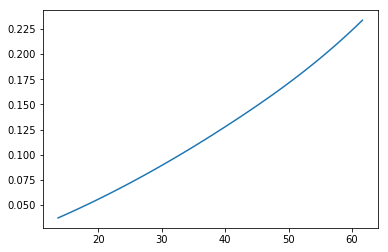

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(p_interp/bar2Pa, solubility_interp, label='Dow data')
ax.errorbar(p_pa/bar2Pa, solubility, yerr=sigma_solubility, fmt='g^', label='measurement')
ax.set_xlabel('Pressure [bar]')
ax.set_ylabel('Solubility')
ax.legend(loc='best')

In [ ]:
sigma_p_pa

In [ ]:
f(24.5E5)

In [ ]:
p_pa